In [1]:
!nvidia-smi

Thu Nov 21 07:06:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [6]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.5/112.6 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [4]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

100% 5.35M/5.35M [00:00<00:00, 183MB/s]
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

image 1/1 /content/IMG_3073.jpg: 640x480 1 refrigerator, 46.5ms
Speed: 13.7ms preprocess, 46.5ms inference, 862.3ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


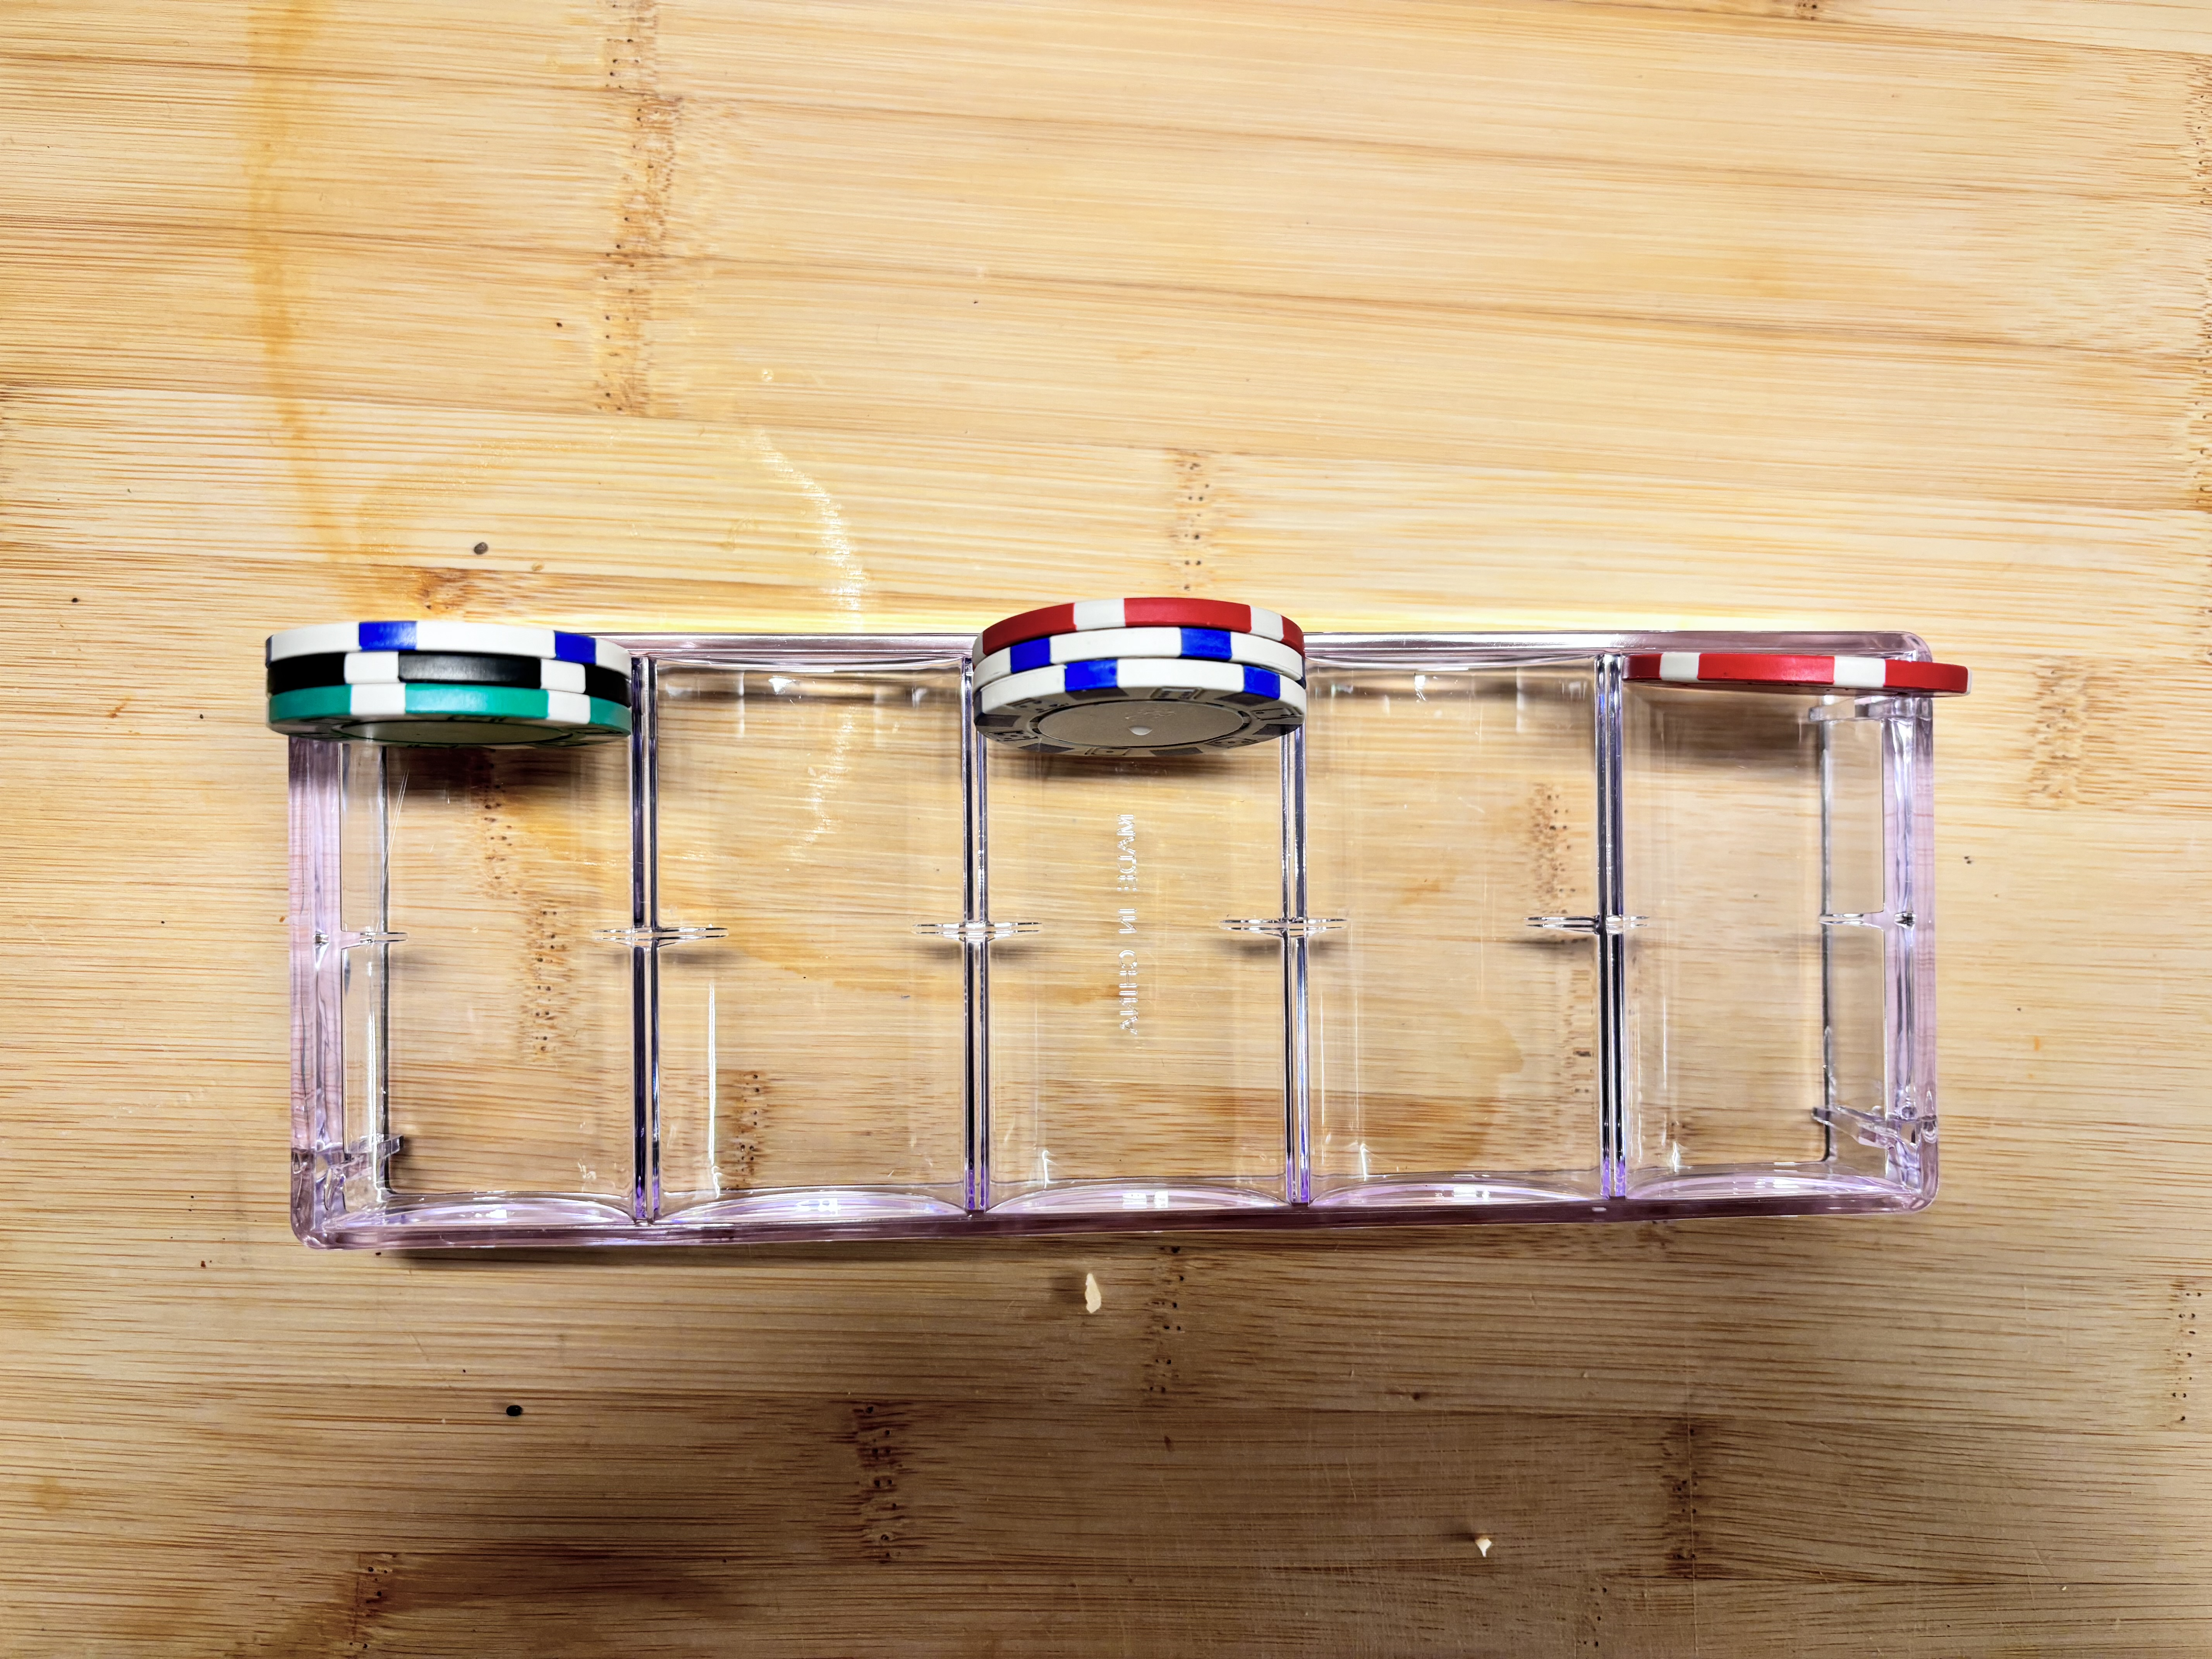

In [5]:
from IPython.display import Image as IPyImage

IPyImage(filename='/content/IMG_3073.jpg', width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [ ]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://media.roboflow.com/notebooks/examples/dog.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]


0: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 60.1ms
Speed: 3.9ms preprocess, 60.1ms inference, 924.2ms postprocess per image at shape (1, 3, 640, 384)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [ ]:
result.boxes.xyxy

tensor([[3.0705e+02, 6.4341e+02, 5.2919e+02, 1.2558e+03],
        [6.1400e+01, 2.4994e+02, 6.5165e+02, 9.7412e+02],
        [1.7803e+00, 3.5551e+02, 6.3404e+02, 1.2788e+03],
        [1.1933e+00, 3.5620e+02, 3.8455e+02, 1.2776e+03],
        [6.2615e+02, 7.1818e+02, 6.9975e+02, 7.8754e+02]], device='cuda:0')

In [ ]:
result.boxes.conf

tensor([0.6832, 0.6284, 0.5941, 0.3923, 0.3875], device='cuda:0')

In [ ]:
result.boxes.cls

tensor([26., 16.,  0.,  0.,  2.], device='cuda:0')

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [ ]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

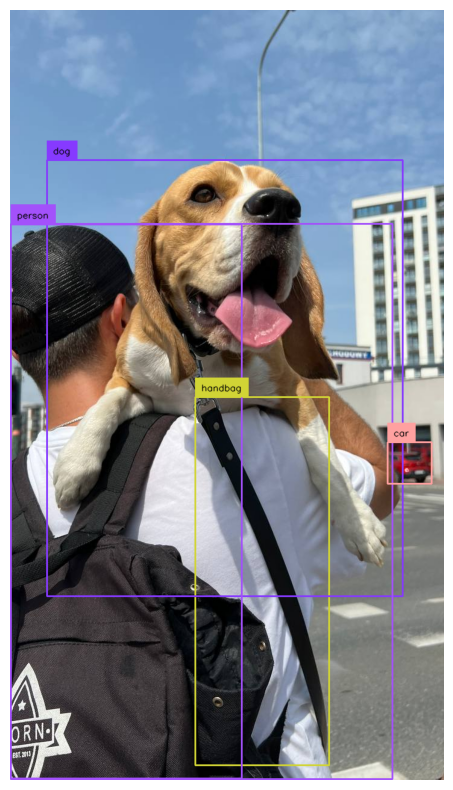

In [ ]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="YqWhQYsIfGAp6I7eFaSN")
project = rf.workspace("poker-chips-annotation").project("poker-chips-annotation")
version = project.version(1)
dataset = version.download("yolov11")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Poker-Chips-Annotation-1 in yolov11:: 100%|██████████| 23/23 [00:00<00:00, 6312.18it/s]


## Custom Training

In [8]:
!yolo task=detect mode=train model=yolo11s.pt data=/content/drive/MyDrive/Poker_Chips_Detection_YOLO/data.yaml epochs=10 imgsz=640 plots=True

100% 18.4M/18.4M [00:00<00:00, 38.7MB/s]
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/drive/MyDrive/Poker_Chips_Detection_YOLO/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [9]:
!ls runs/detect/train/

args.yaml					    labels.jpg	  train_batch0.jpg
confusion_matrix_normalized.png			    P_curve.png   train_batch1.jpg
confusion_matrix.png				    PR_curve.png  train_batch2.jpg
events.out.tfevents.1732182992.5a7cbaaf8b7c.3820.0  R_curve.png   val_batch0_labels.jpg
F1_curve.png					    results.csv   val_batch0_pred.jpg
labels_correlogram.jpg				    results.png   weights


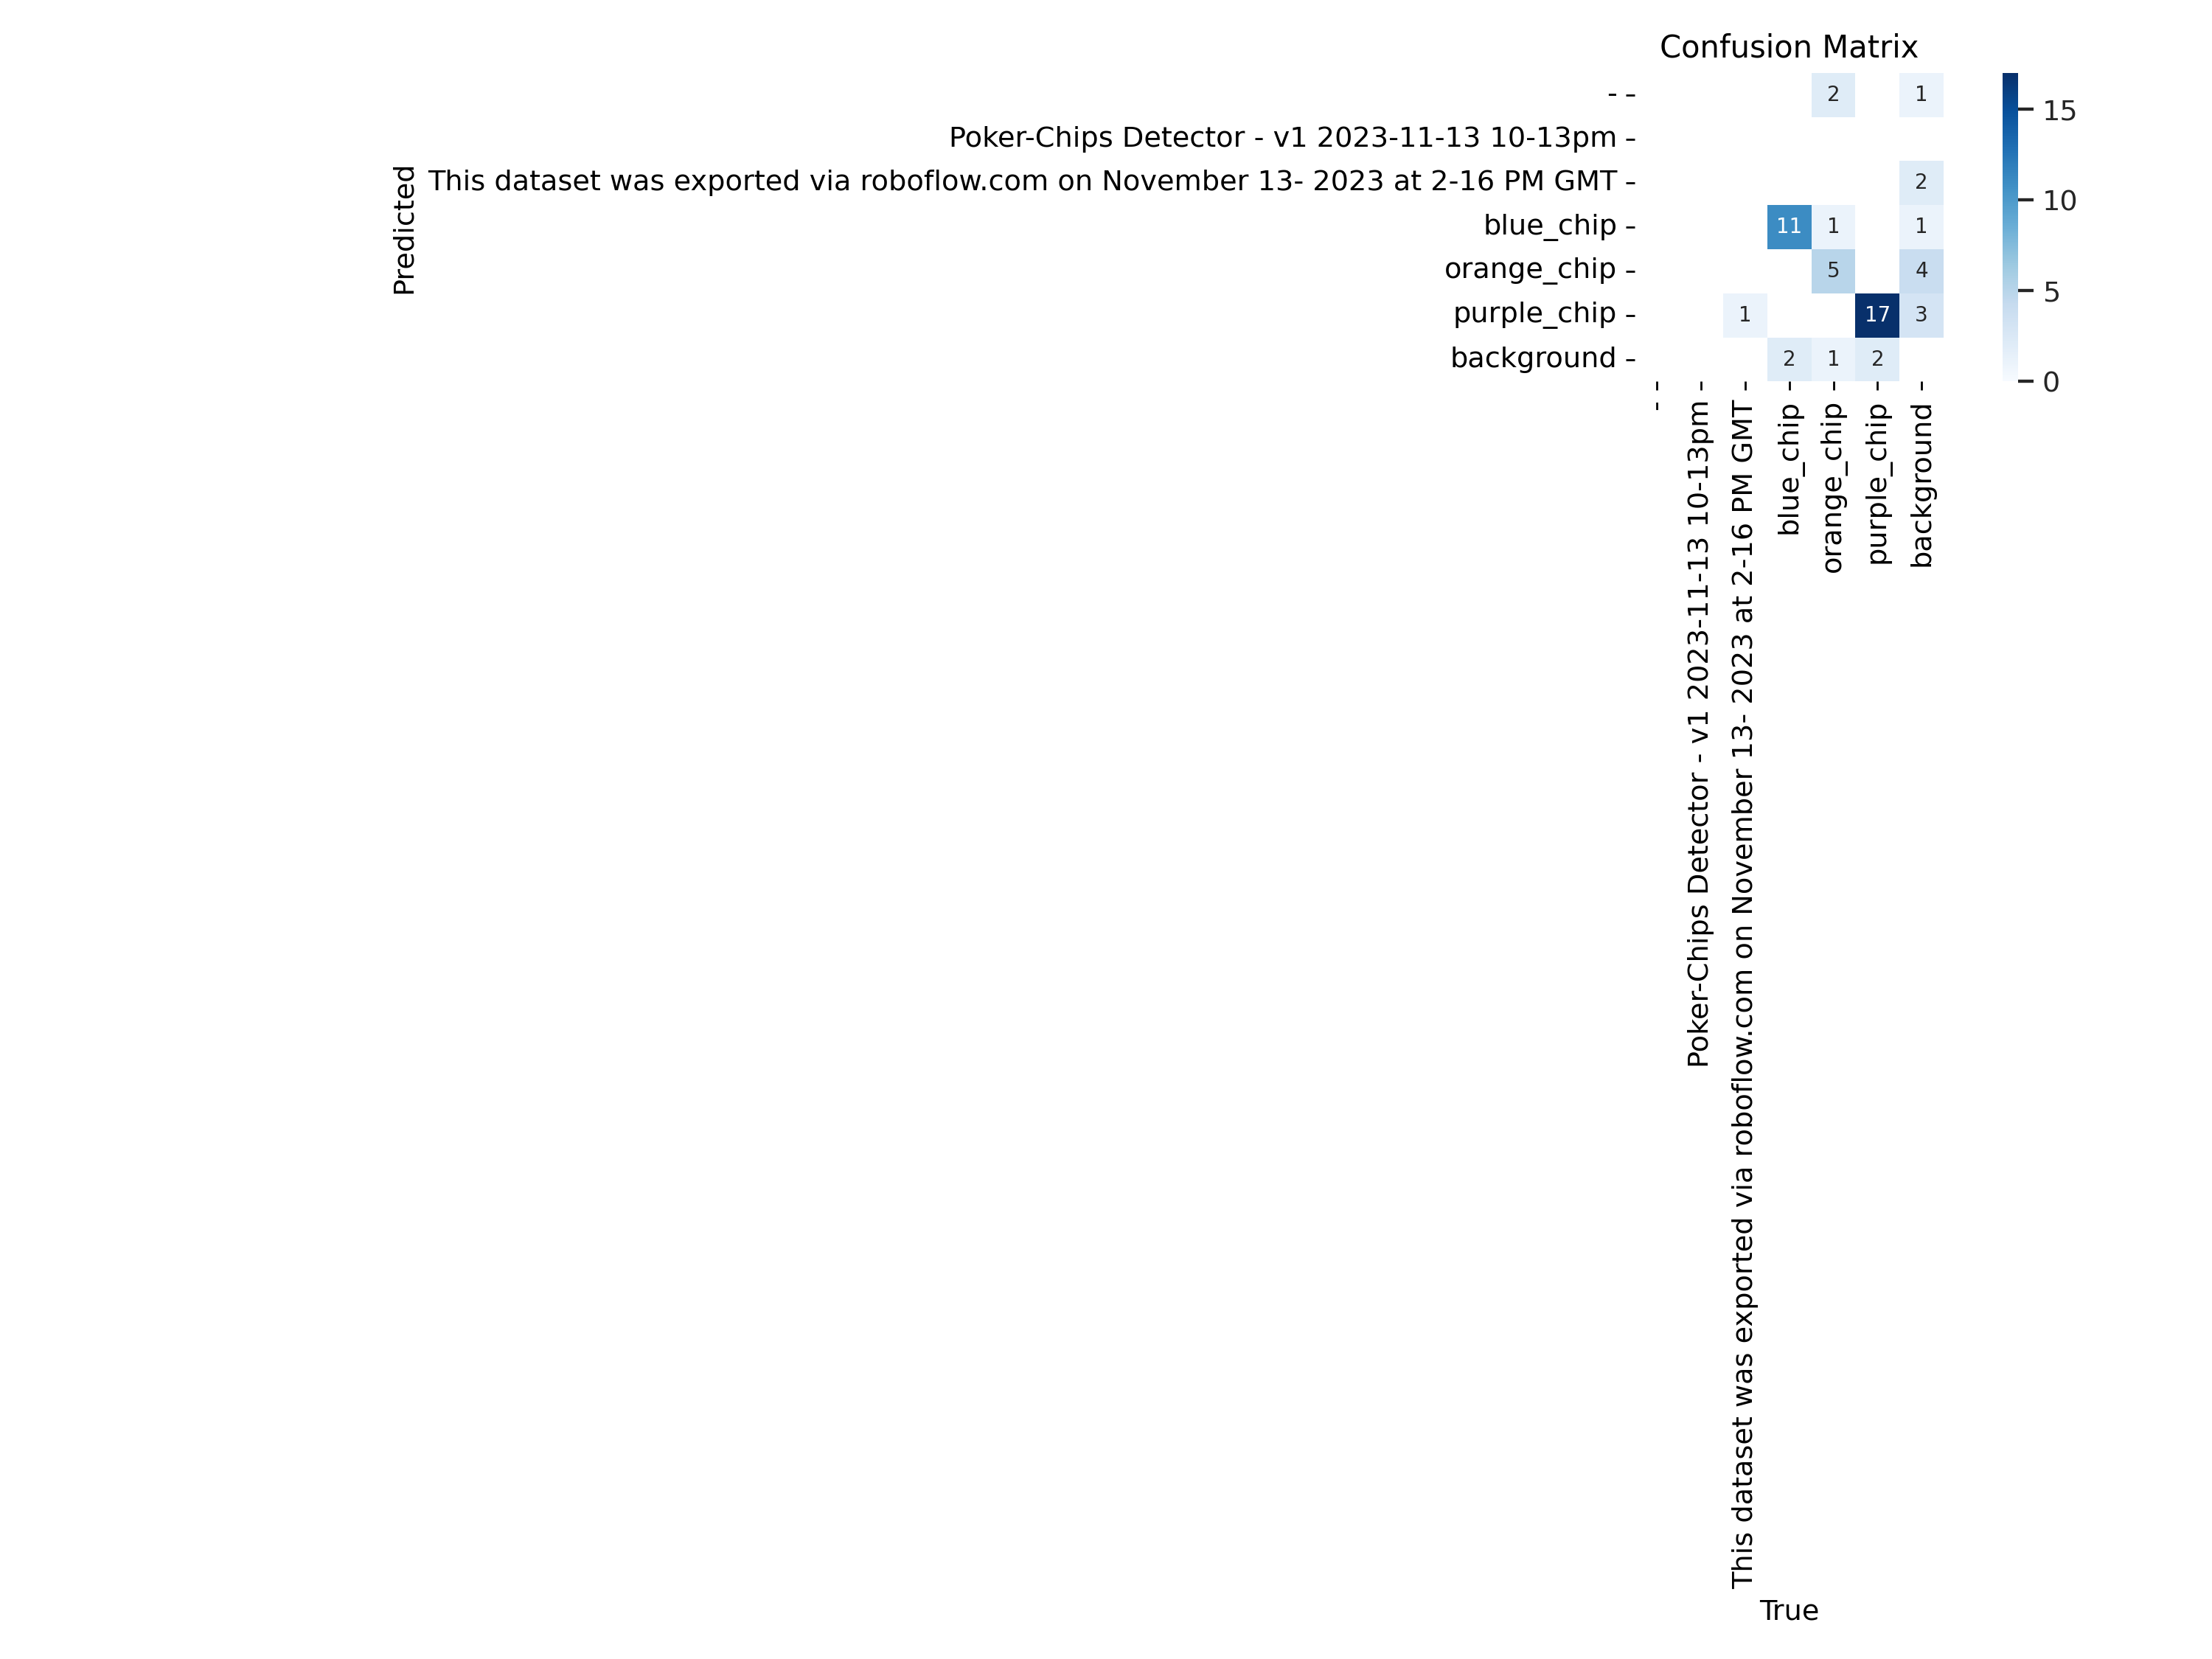

In [10]:
from IPython.display import Image as IPyImage

IPyImage(filename='runs/detect/train/confusion_matrix.png', width=600)

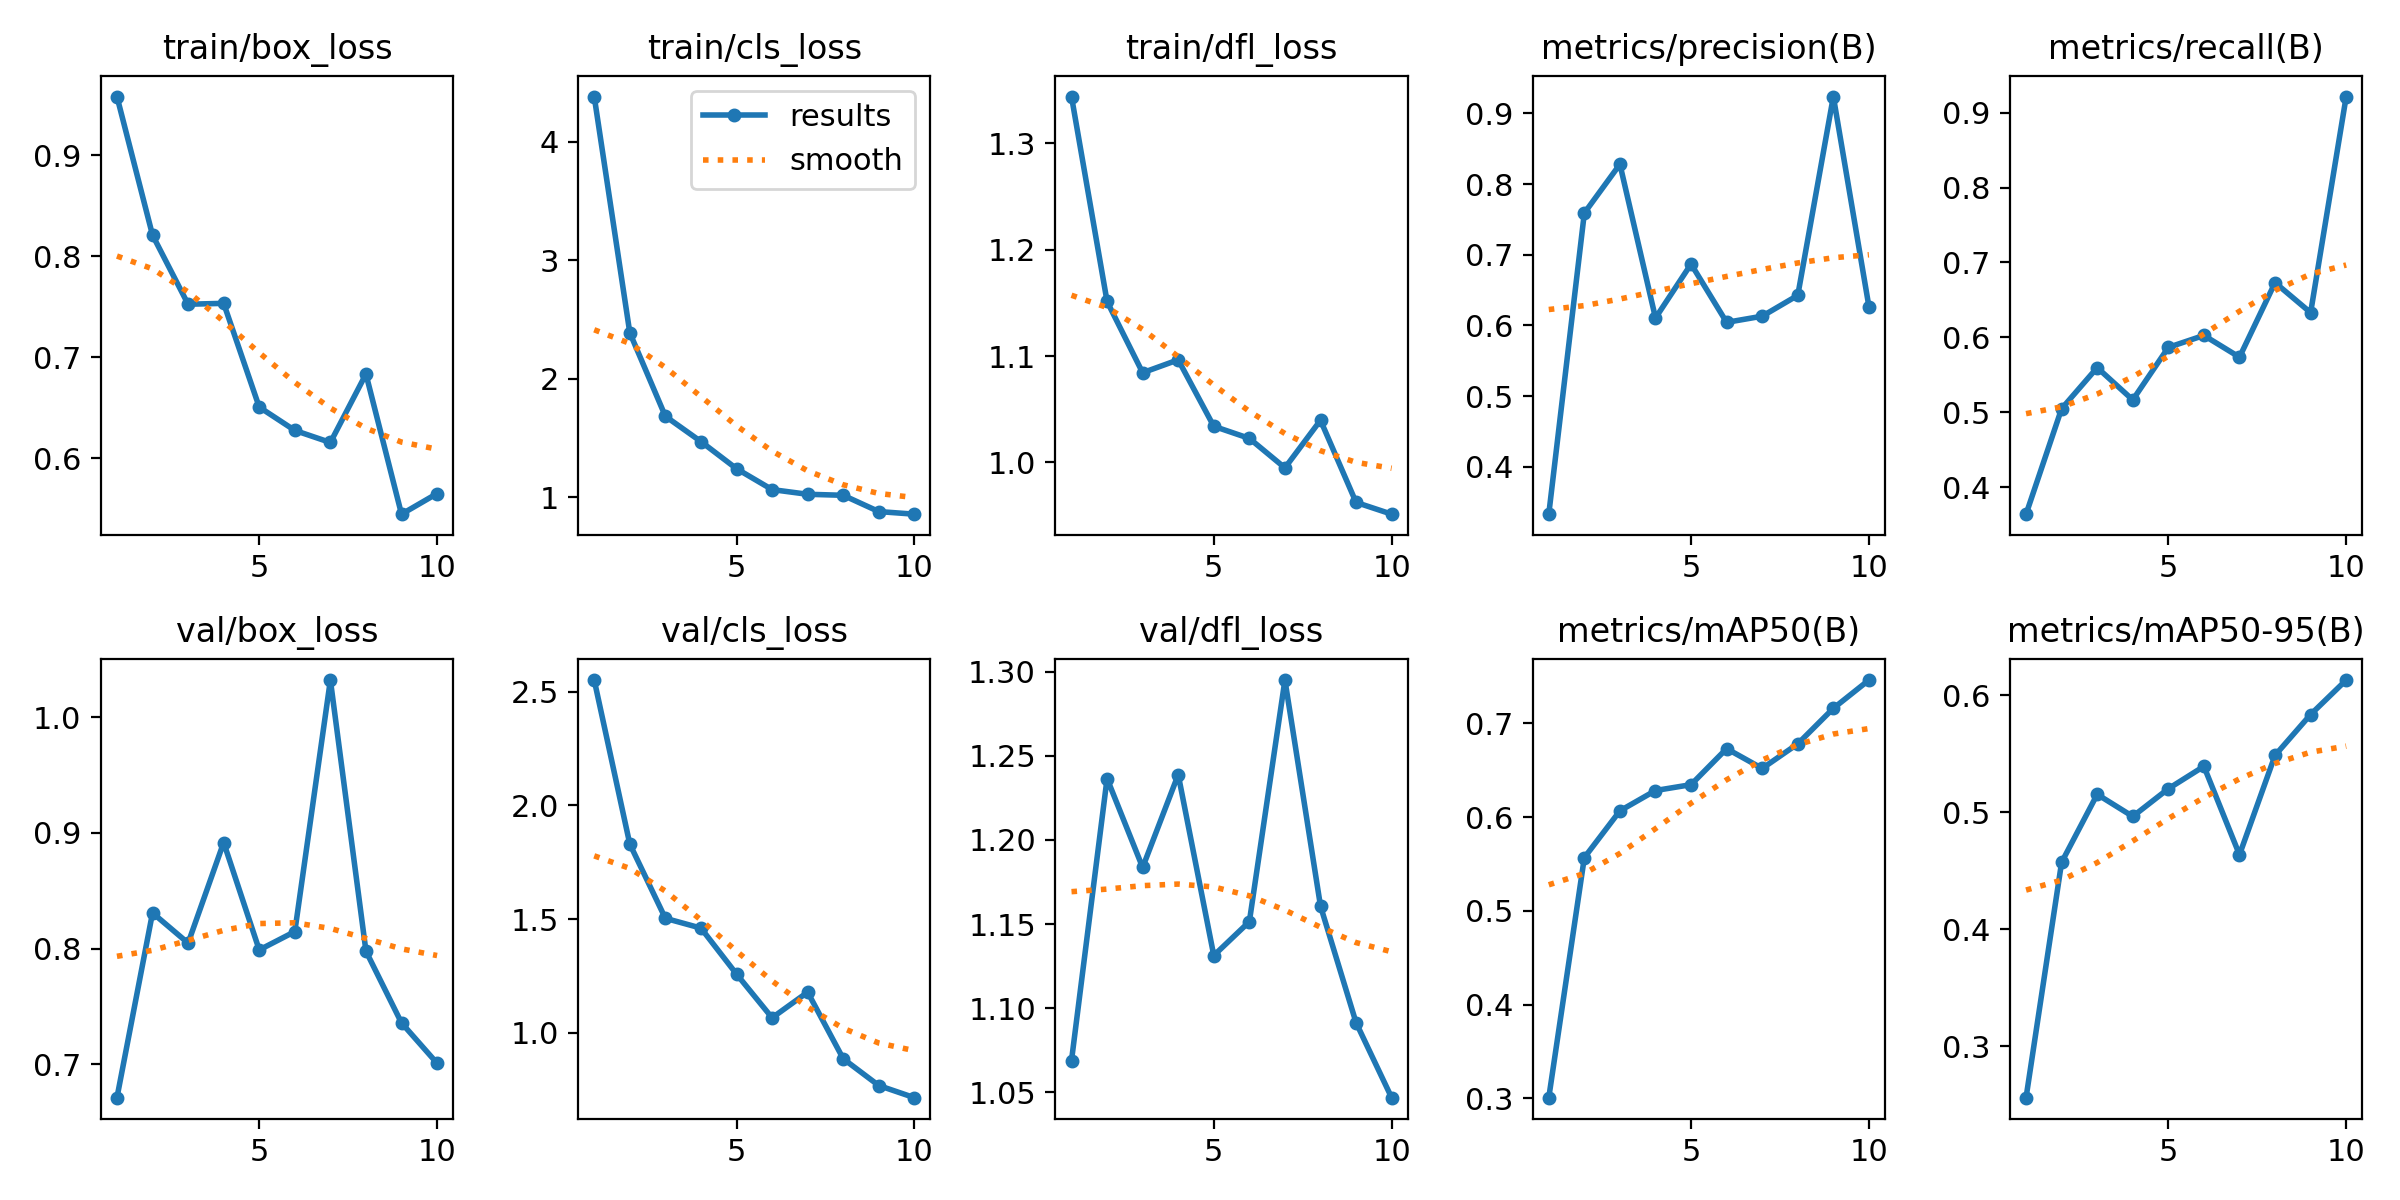

In [11]:
from IPython.display import Image as IPyImage

IPyImage(filename='runs/detect/train/results.png', width=600)

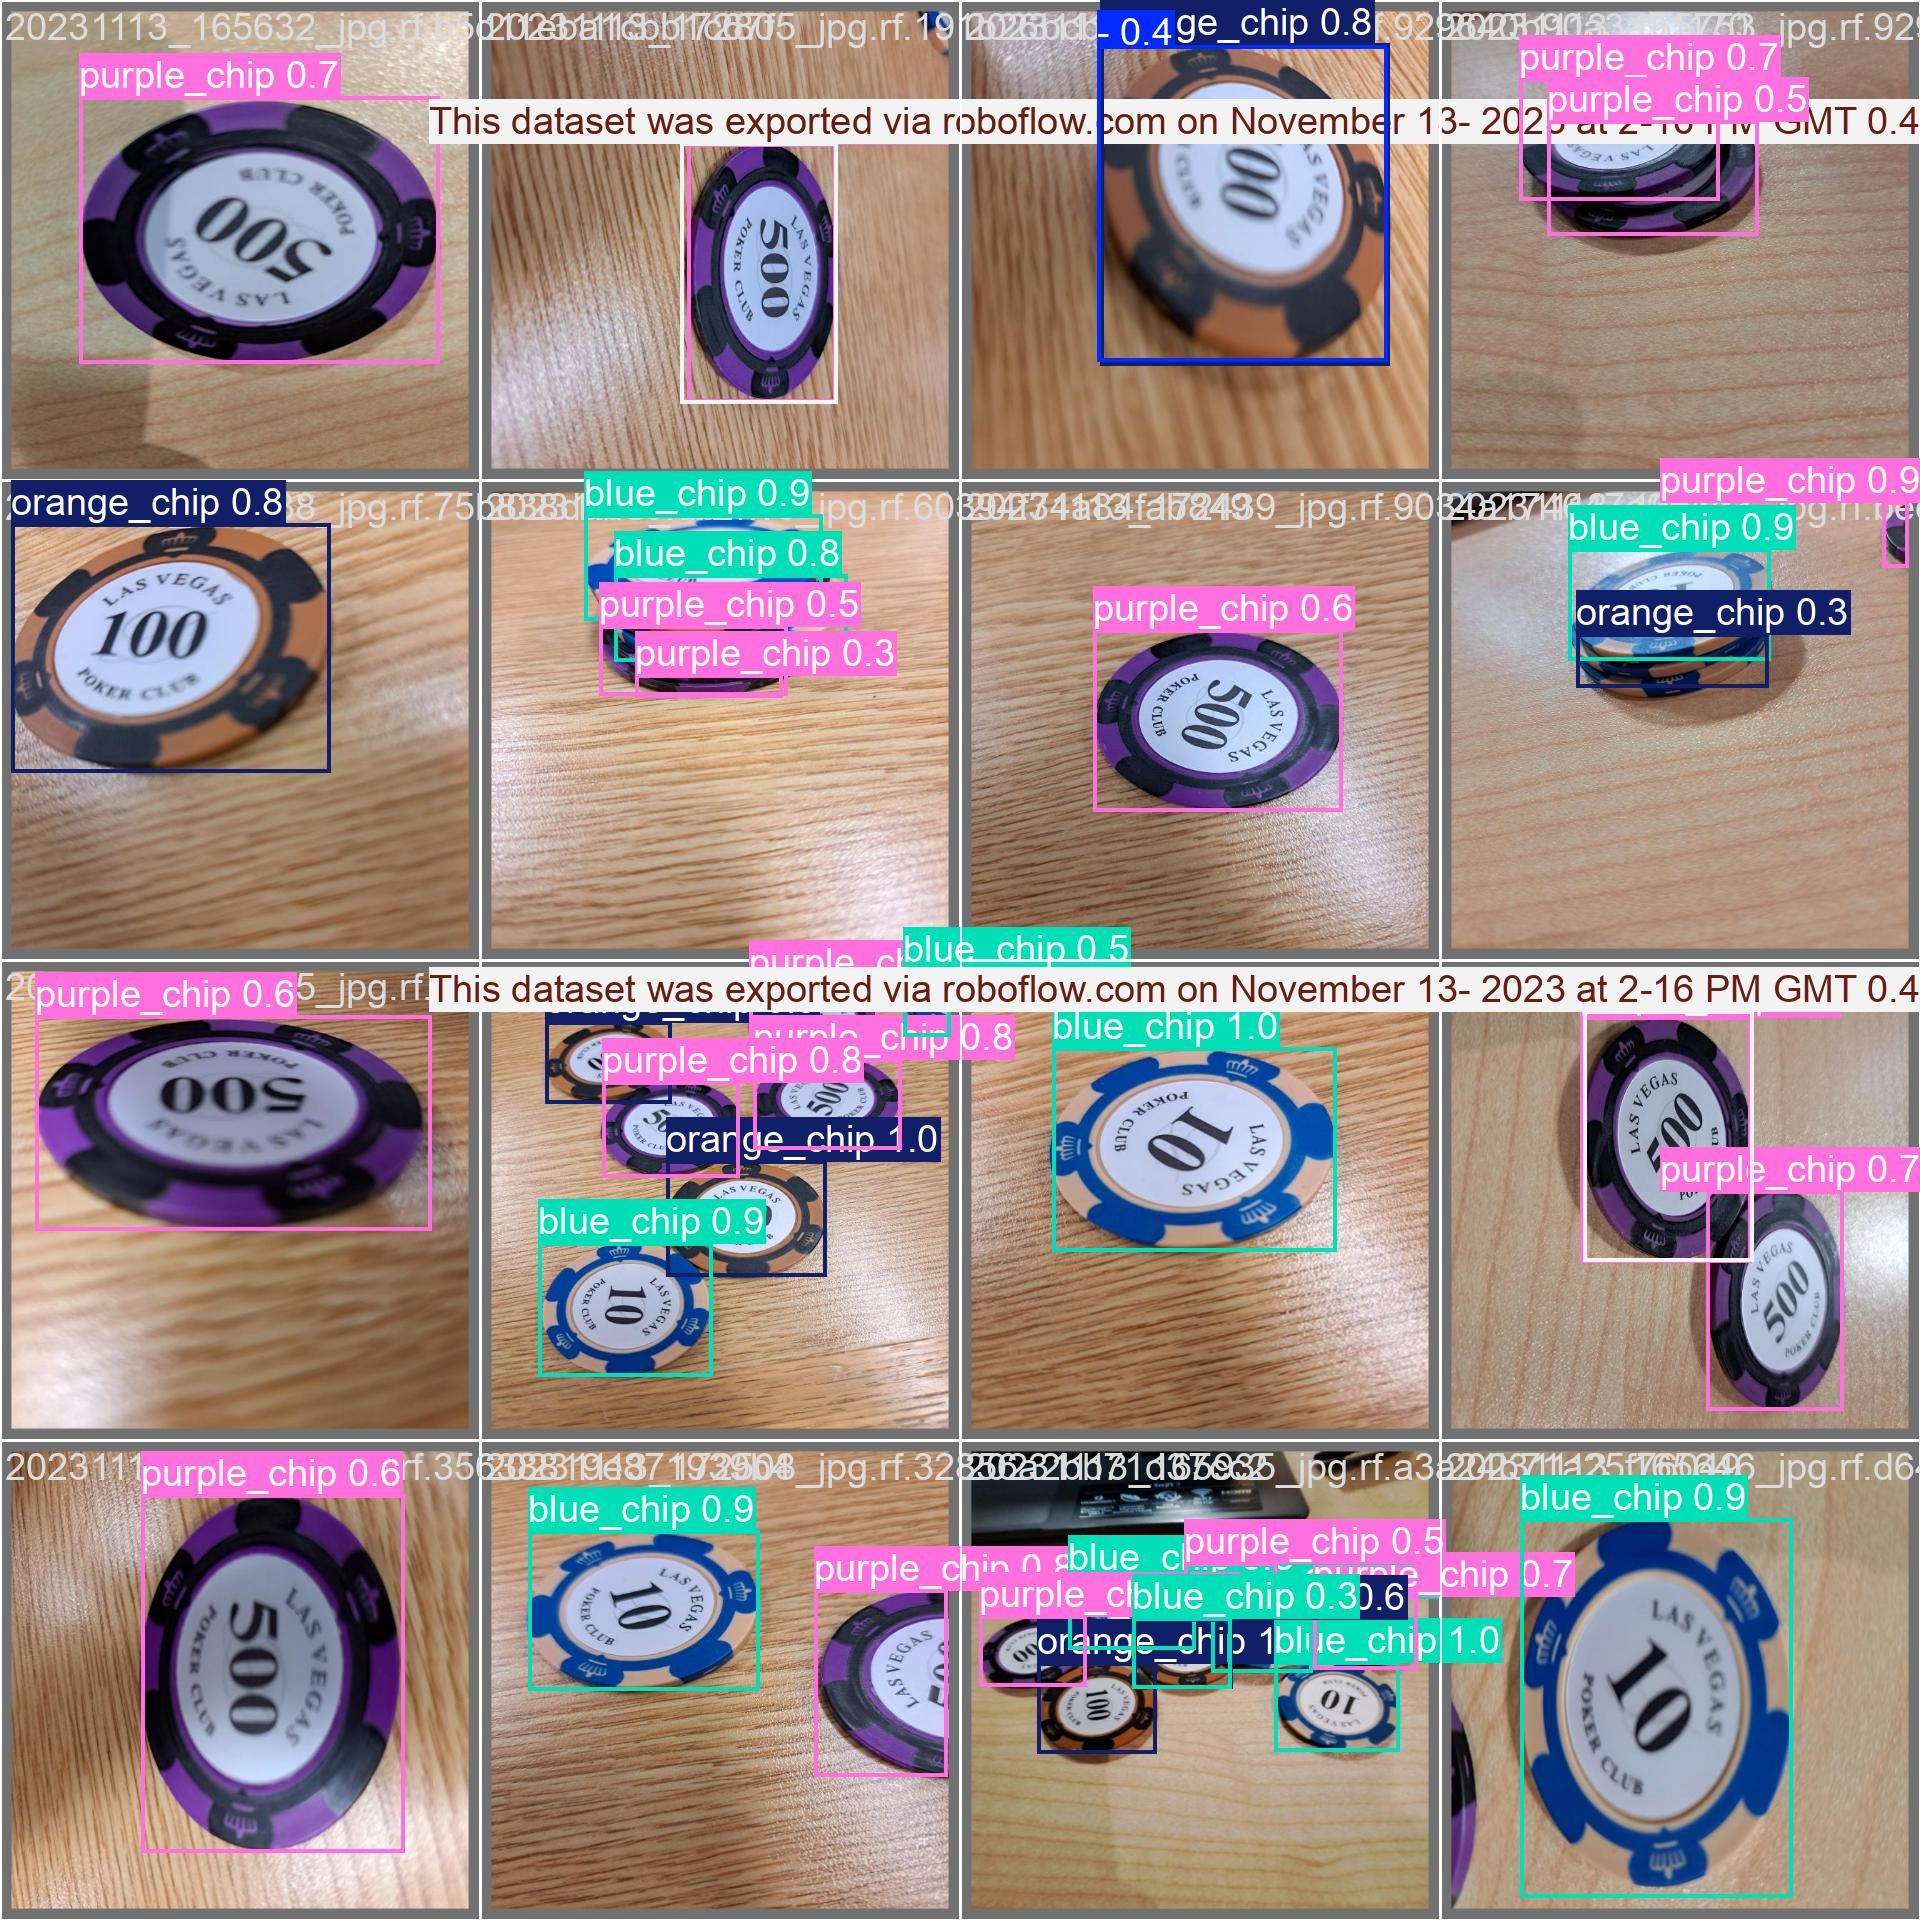

In [12]:
from IPython.display import Image as IPyImage

IPyImage(filename='runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [13]:
!yolo task=detect mode=val model=runs/detect/train/weights/best.pt data=/content/drive/MyDrive/Poker_Chips_Detection_YOLO/data.yaml

Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/drive/MyDrive/Poker_Chips_Detection_YOLO/valid/labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100% 19/19 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 2/2 [00:01<00:00,  1.43it/s]
                   all         19         42      0.627      0.921      0.746      0.612
This dataset was exported via roboflow.com on November 13- 2023 at 2-16 PM GMT          1          1      0.157          1      0.249      0.249
             blue_chip          7         13      0.734       0.85      0.935       0.71
           orange_chip          7          9      0.823      0.889      0.943      0.822
           purple_chip         11         19      0.793      0.947      0.859      0.667
Speed: 4.5ms preprocess, 19.0ms inference, 0.0ms loss, 36.

## Inference with custom model

In [14]:
!yolo task=detect mode=predict model=runs/detect/train/weights/best.pt conf=0.25 source=/content/drive/MyDrive/Poker_Chips_Detection_YOLO/test/images save=True

Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs

image 1/9 /content/drive/MyDrive/Poker_Chips_Detection_YOLO/test/images/20231113_165614_jpg.rf.d6fd3a4d598b35642c0e240d23d714be.jpg: 640x640 1 -, 1 orange_chip, 15.7ms
image 2/9 /content/drive/MyDrive/Poker_Chips_Detection_YOLO/test/images/20231113_165649_jpg.rf.5df70d06e3ccf0c6d34d16778ae9fd0e.jpg: 640x640 2 blue_chips, 2 orange_chips, 15.7ms
image 3/9 /content/drive/MyDrive/Poker_Chips_Detection_YOLO/test/images/20231113_165654_jpg.rf.c6c1228c9bfe4a6b567b7d6d650b4ca6.jpg: 640x640 3 blue_chips, 2 purple_chips, 15.7ms
image 4/9 /content/drive/MyDrive/Poker_Chips_Detection_YOLO/test/images/20231113_165744_jpg.rf.bce3ca91d6a961f3300dca2eff150517.jpg: 640x640 2 orange_chips, 15.6ms
image 5/9 /content/drive/MyDrive/Poker_Chips_Detection_YOLO/test/images/20231113_165804_jpg.rf.e80e33438e02770e2648afd26c77b1c9.jpg: 640x640 1 bl

**NOTE:** Let's take a look at few results.

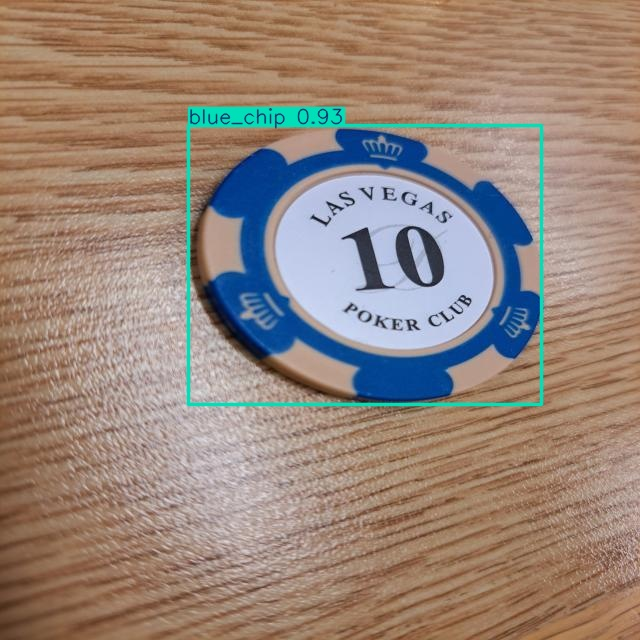

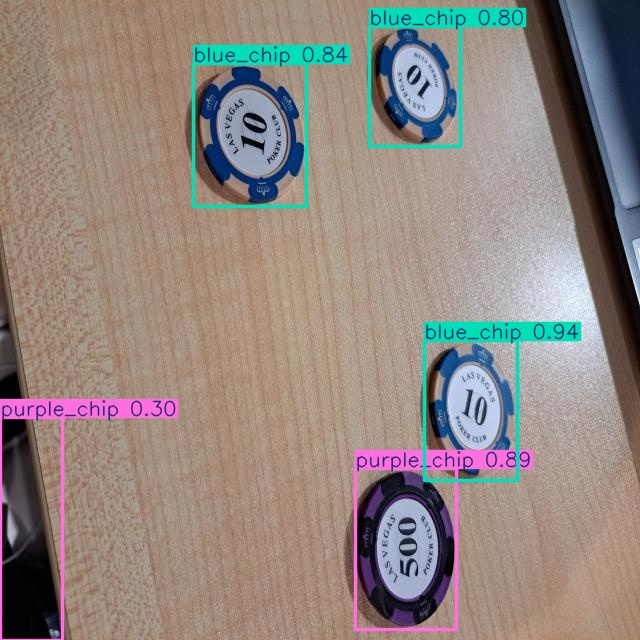

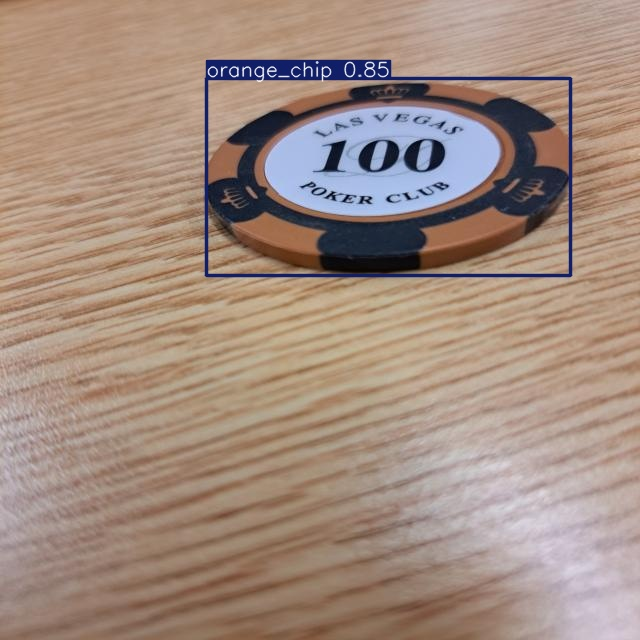

In [15]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [ ]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

In [ ]:
!pip install inference

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get('ROBOFLOW_API_KEY'))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.